# Imports

In [1]:
import numpy as np
import pandas as pd
import keijzer_exogan as ke
import glob
import copy
import seaborn as sns
import math

import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import Pool


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# Getting MakeAI file paths

In [2]:
#path = '/datb/16011015/MakeAI' #datascience server
path = '/shared/datasets/16011015/MakeAI_SURFsara/*/*/' # gpu server

# file paths
trans_ = glob.glob(path+'/*/trans')[:10**3]
params_ = glob.glob(path+'/*/parameters')[:10**3]
ariels = glob.glob(path+'/*/contr_trans_ARIEL')[:10**3]

# Loading trans

In [3]:
trans = np.loadtxt(trans_[0])
trans.shape

(515, 4)

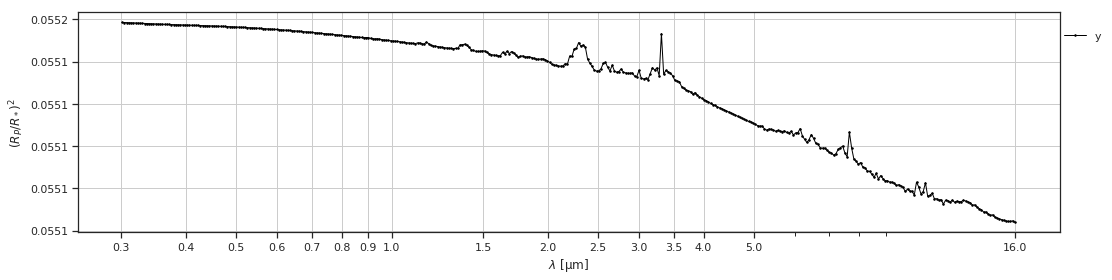

In [4]:
x = trans[:, 0]
y = trans[:, 1]


ke.plot_trans(x,y, x_max=16)

# Fix the R=200 instead of R=100 problem. 
Take the x values from MakeAI as close to the ExoGAN x points as possible

In [5]:
def match_arcis_to_exogan_lambda_values(trans):
    """
    trans: np.loadtxt() loaded trans file from ARCiS MakeAI
    output: trans converted to dataframe that match the ExoGAN wavelengths up to 16 micron.
    
    Example:
    exogan wavelengths: 0.30, 0.35. 0.40
    trans wavelengths: 0.31, 0.32, 0.35, 0.39, 0.45
    Then the output df would contain: 0.31, 0.35, 0.39
    """
    
    """prepare exogan wavelengths"""
    # load exogan wavelengths to match trans to
    df = pd.read_csv('wavelengths_and_indices.csv', header=None, skiprows=[0], usecols=[1]) # load wavelengths
    df.columns = ['x']
    df = df.loc[df['x'] <= 16] # select only wavelengths <= 16
    
    # dfe for 'df exogan'
    dfe = df.iloc[::-1] # flip rows
    dfe = dfe.reset_index(drop=True) # reset index
    
    """prepare trans"""
    x = trans[:, 0] # expected MakeAI ARCiS format
    y = trans[:, 1]
    
    # dfa for 'df ARCiS'
    dfa = pd.DataFrame([x,y]).T
    dfa.columns = ['x', 'y']
    
    """Get the lambda values that are the closest match to exogan"""
    closest_matches = []
    for target in dfe['x']:
        delta_previous = 99999
        previous_point = 99999

        for current_point in dfa['x']: # loop over all points in dfa
            delta_current = np.abs(target-current_point) # the absolute difference between the target and selected point

            if delta_current < delta_previous:
                delta_previous = delta_current
                previous_point = current_point

            else:
                closest_matches.append(previous_point)
                break
    
    dfa_selection = dfa[dfa['x'].isin(closest_matches)] # grab the values from dfa that match closest_matches
    
    return dfa_selection

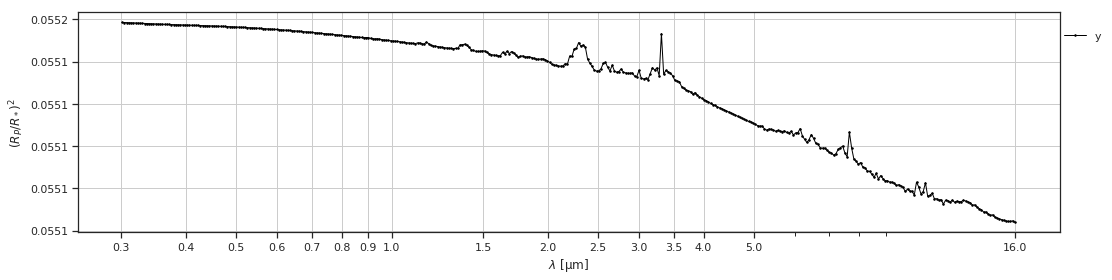

In [6]:
trans = np.loadtxt(trans_[0])
df = match_arcis_to_exogan_lambda_values(trans)

ke.plot_trans(df.x, df.y)

# Get global min max values to use for normalization

In [7]:
data = [(trans_file) for trans_file in tqdm(trans_)]

def f(t):
    trans_file = t
    return match_arcis_to_exogan_lambda_values(np.loadtxt(trans_file))

100%|██████████| 1000/1000 [00:00<00:00, 1695353.27it/s]


In [8]:
%%time
pool = Pool() # server has 2x 12 cores -> Pool(processes=24)
results = pool.map(f, data, chunksize=1)

CPU times: user 397 ms, sys: 112 ms, total: 509 ms
Wall time: 5 s


In [9]:
%%time
pool.close()
pool.join()
pool.terminate() # not nice but meh, pool.join() gets stuck... https://stackoverflow.com/questions/15314189/python-multiprocessing-pool-hangs-at-join

CPU times: user 2.79 ms, sys: 708 µs, total: 3.5 ms
Wall time: 57.2 ms


In [10]:
dfs = results

In [11]:
mins = [df.y.min() for df in tqdm(dfs)]
maxs = [df.y.max() for df in tqdm(dfs)]

100%|██████████| 1000/1000 [00:00<00:00, 11336.81it/s]


In [12]:
min(mins), max(maxs)

(0.0004942788, 0.10816142)

# Get params

In [13]:
def get_arcis_makeai_params(path_to_file):
    """
    Returns dict {'param':value}
    """
    params = np.genfromtxt(path_to_file, usecols=np.arange(0,3), skip_header=1, dtype='str')
    params[:,2] = params[:,2]
    params = params[:, [0,2]]
    
    params = dict(params)
    
    for key in params:
        params[key] = float(params[key])
    
    return params

In [14]:
get_arcis_makeai_params(params_[0])

{'Dplanet': 0.10790548,
 'Rp': 2.3326473,
 'Mp': 8.2841316,
 'betaT': 0.24771324,
 'TeffP': 22.89249,
 'fdry': 6.7441871,
 'fwet': 0.10276277,
 'cloud1:Sigmadot': 7.1620629e-15,
 'cloud1:Kzz': 738466860.0,
 'Tform': 100.0,
 'f_dry': 6.7441871,
 'f_wet': 0.10276277,
 'COratio': 1.1382166,
 'metallicity': 0.47734193}

# Get abundances

In [15]:
def get_makeai_abundances(path_to_file):
    """
    Opens path_to_file and returns dict with abundances
    path_to_file: 'contr_trans_ARIEL' file path
    
    """
    
    
    # Open file, read raw data
    with open(path_to_file) as file:
        words = file.readlines()
        abundances = words[:17]
        
    arr = np.char.split(abundances)
    
    # Put names & values in lists
    ab_names = []
    ab_values = []
    for array in arr:
        ab_names.append(array[1])
        ab_values.append(array[-1])
    
    # Convert these lists to dict like exogan params
    abundances = np.array([ab_names, ab_values])
    
    abundances = dict.fromkeys(ab_names, 0)
    
    for i,key in enumerate(abundances.keys()):
        abundances[key] = float(ab_values[i])
        
    return abundances

In [16]:
get_makeai_abundances(ariels[0])

{'T': 210.047,
 'P': 1.145,
 'H2O': 0.0005082,
 'CO2': 3.034e-28,
 'CO': 3.741e-33,
 'CH4': 0.001568,
 'SO2': 5.892e-60,
 'NH3': 0.0001157,
 'HCN': 1.51e-46,
 'C2H2': 1.022e-74,
 'C2H4': 3.07e-45,
 'H2': 0.8515,
 'He': 0.1458,
 'Na': 1.811e-17,
 'K': 1.221e-19,
 'TiO': 3.764e-18,
 'VO': 6.01e-12}

# Get min max param and abundance info for normalization

In [17]:
# get list of all param dicts

params_dicts = []
for i in range(len(tqdm(ariels))): # for debugging purposes only take the first 5
    try:
        params = get_arcis_makeai_params(params_[i])
        abundances = get_makeai_abundances(ariels[i])

        # create one dict with params and abundances, calling it params 
        params = {**params, **abundances}

        params_dicts.append(params)
    except:
        pass # catch and pass the flawwed files

  0%|          | 0/1000 [00:00<?, ?it/s]


In [18]:
len(params_dicts)

827

In [19]:
params_dicts[0] # display a dict

{'Dplanet': 0.10790548,
 'Rp': 2.3326473,
 'Mp': 8.2841316,
 'betaT': 0.24771324,
 'TeffP': 22.89249,
 'fdry': 6.7441871,
 'fwet': 0.10276277,
 'cloud1:Sigmadot': 7.1620629e-15,
 'cloud1:Kzz': 738466860.0,
 'Tform': 100.0,
 'f_dry': 6.7441871,
 'f_wet': 0.10276277,
 'COratio': 1.1382166,
 'metallicity': 0.47734193,
 'T': 210.047,
 'P': 1.145,
 'H2O': 0.0005082,
 'CO2': 3.034e-28,
 'CO': 3.741e-33,
 'CH4': 0.001568,
 'SO2': 5.892e-60,
 'NH3': 0.0001157,
 'HCN': 1.51e-46,
 'C2H2': 1.022e-74,
 'C2H4': 3.07e-45,
 'H2': 0.8515,
 'He': 0.1458,
 'Na': 1.811e-17,
 'K': 1.221e-19,
 'TiO': 3.764e-18,
 'VO': 6.01e-12}

In [20]:
dfs = [pd.DataFrame(params_dict, index=[0]) for params_dict in tqdm(params_dicts)]
df = pd.concat(dfs)
df = df.reset_index(drop=True)

100%|██████████| 827/827 [00:01<00:00, 681.58it/s]


In [21]:
df.describe()

,Dplanet,Rp,Mp,betaT,TeffP,fdry,fwet,cloud1:Sigmadot,cloud1:Kzz,Tform,...,NH3,HCN,C2H2,C2H4,H2,He,Na,K,TiO,VO
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,8.270000e+02,8.270000e+02,827.0,...,8.230000e+02,8.230000e+02,8.230000e+02,8.230000e+02,823.000000,823.000000,8.230000e+02,8.230000e+02,8.230000e+02,8.230000e+02
mean,0.055245,1.718604,4.951975,0.181429,79.855368,2.264870,2.219916,5.050670e-13,1.214651e+09,100.0,...,4.987174e-05,2.886102e-08,1.637877e-08,1.011866e-10,0.849310,0.145175,2.420381e-06,1.279079e-07,7.214433e-09,3.625557e-10
std,0.044936,0.737147,2.783385,0.042839,69.549217,2.582597,2.564705,1.517910e-12,2.242127e+09,0.0,...,5.364727e-05,2.333458e-07,3.401439e-07,8.860838e-10,0.018228,0.001479,5.347868e-06,3.014502e-07,4.524621e-08,2.685627e-09
min,0.010070,0.359299,0.051526,0.100199,10.006903,0.100067,0.100229,1.000204e-19,1.014727e+06,100.0,...,1.052000e-09,3.104000e-62,4.791000e-99,7.190000e-59,0.598600,0.125300,3.649000e-55,1.975000e-58,1.656000e-59,9.166000e-43
25%,0.020411,1.062533,2.583130,0.146587,23.158641,0.334562,0.333309,6.969265e-18,1.022396e+07,100.0,...,5.896000e-07,8.117000e-39,1.657000e-61,1.824000e-38,0.851100,0.145200,1.001750e-24,6.126000e-27,4.073500e-30,1.163500e-30
50%,0.039361,1.681432,4.838264,0.184004,51.586472,1.063582,1.005871,4.978983e-16,1.044071e+08,100.0,...,8.366000e-06,1.149000e-21,7.606000e-31,2.926000e-22,0.852700,0.145500,3.584000e-11,7.856000e-13,3.130000e-19,6.089000e-20
75%,0.075664,2.374672,7.397306,0.216797,126.476000,3.573244,3.367309,6.981408e-14,1.101990e+09,100.0,...,1.146000e-04,2.119000e-10,8.461000e-13,1.322000e-12,0.853500,0.145600,1.681500e-06,7.176000e-08,1.453500e-10,2.404000e-11
max,0.198995,2.998385,9.990271,0.249983,249.298040,9.948930,9.982814,9.960893e-12,9.982865e+09,100.0,...,1.158000e-04,5.324000e-06,9.697000e-06,2.226000e-08,0.854100,0.145900,2.871000e-05,1.766000e-06,7.879000e-07,5.375000e-08


# Drop NaNs and +- inf
Occuring from bugs in ARCiS

In [22]:
df.isna().sum()

Dplanet            0
Rp                 0
Mp                 0
betaT              0
TeffP              0
fdry               0
fwet               0
cloud1:Sigmadot    0
cloud1:Kzz         0
Tform              0
f_dry              0
f_wet              0
COratio            0
metallicity        0
T                  4
P                  4
H2O                4
CO2                4
CO                 4
CH4                4
SO2                4
NH3                4
HCN                4
C2H2               4
C2H4               4
H2                 4
He                 4
Na                 4
K                  4
TiO                4
VO                 4
dtype: int64

In [23]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

df.describe()

,Dplanet,Rp,Mp,betaT,TeffP,fdry,fwet,cloud1:Sigmadot,cloud1:Kzz,Tform,...,NH3,HCN,C2H2,C2H4,H2,He,Na,K,TiO,VO
count,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,8.230000e+02,8.230000e+02,823.0,...,8.230000e+02,8.230000e+02,8.230000e+02,8.230000e+02,823.000000,823.000000,8.230000e+02,8.230000e+02,8.230000e+02,8.230000e+02
mean,0.054776,1.719994,4.951009,0.181790,80.118512,2.265368,2.206281,4.971950e-13,1.220491e+09,100.0,...,4.987174e-05,2.886102e-08,1.637877e-08,1.011866e-10,0.849310,0.145175,2.420381e-06,1.279079e-07,7.214433e-09,3.625557e-10
std,0.044531,0.737985,2.783892,0.042628,69.611301,2.583257,2.555161,1.499507e-12,2.246005e+09,0.0,...,5.364727e-05,2.333458e-07,3.401439e-07,8.860838e-10,0.018228,0.001479,5.347868e-06,3.014502e-07,4.524621e-08,2.685627e-09
min,0.010070,0.359299,0.051526,0.100199,10.006903,0.100067,0.100229,1.000204e-19,1.014727e+06,100.0,...,1.052000e-09,3.104000e-62,4.791000e-99,7.190000e-59,0.598600,0.125300,3.649000e-55,1.975000e-58,1.656000e-59,9.166000e-43
25%,0.020403,1.062533,2.583130,0.147905,23.263131,0.334562,0.330463,6.969265e-18,1.043365e+07,100.0,...,5.896000e-07,8.117000e-39,1.657000e-61,1.824000e-38,0.851100,0.145200,1.001750e-24,6.126000e-27,4.073500e-30,1.163500e-30
50%,0.039056,1.681432,4.838264,0.184676,51.820872,1.063582,1.001491,4.844928e-16,1.061739e+08,100.0,...,8.366000e-06,1.149000e-21,7.606000e-31,2.926000e-22,0.852700,0.145500,3.584000e-11,7.856000e-13,3.130000e-19,6.089000e-20
75%,0.075185,2.377842,7.397306,0.217284,126.706175,3.573244,3.353325,6.656192e-14,1.115293e+09,100.0,...,1.146000e-04,2.119000e-10,8.461000e-13,1.322000e-12,0.853500,0.145600,1.681500e-06,7.176000e-08,1.453500e-10,2.404000e-11
max,0.198995,2.998385,9.990271,0.249983,249.298040,9.948930,9.982814,9.960893e-12,9.982865e+09,100.0,...,1.158000e-04,5.324000e-06,9.697000e-06,2.226000e-08,0.854100,0.145900,2.871000e-05,1.766000e-06,7.879000e-07,5.375000e-08


In [24]:
df.isna().sum()

Dplanet            0
Rp                 0
Mp                 0
betaT              0
TeffP              0
fdry               0
fwet               0
cloud1:Sigmadot    0
cloud1:Kzz         0
Tform              0
f_dry              0
f_wet              0
COratio            0
metallicity        0
T                  0
P                  0
H2O                0
CO2                0
CO                 0
CH4                0
SO2                0
NH3                0
HCN                0
C2H2               0
C2H4               0
H2                 0
He                 0
Na                 0
K                  0
TiO                0
VO                 0
dtype: int64

# Plot hists of original data

In [25]:
df.columns

Index(['Dplanet', 'Rp', 'Mp', 'betaT', 'TeffP', 'fdry', 'fwet',
       'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio',
       'metallicity', 'T', 'P', 'H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN',
       'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'],
      dtype='object')

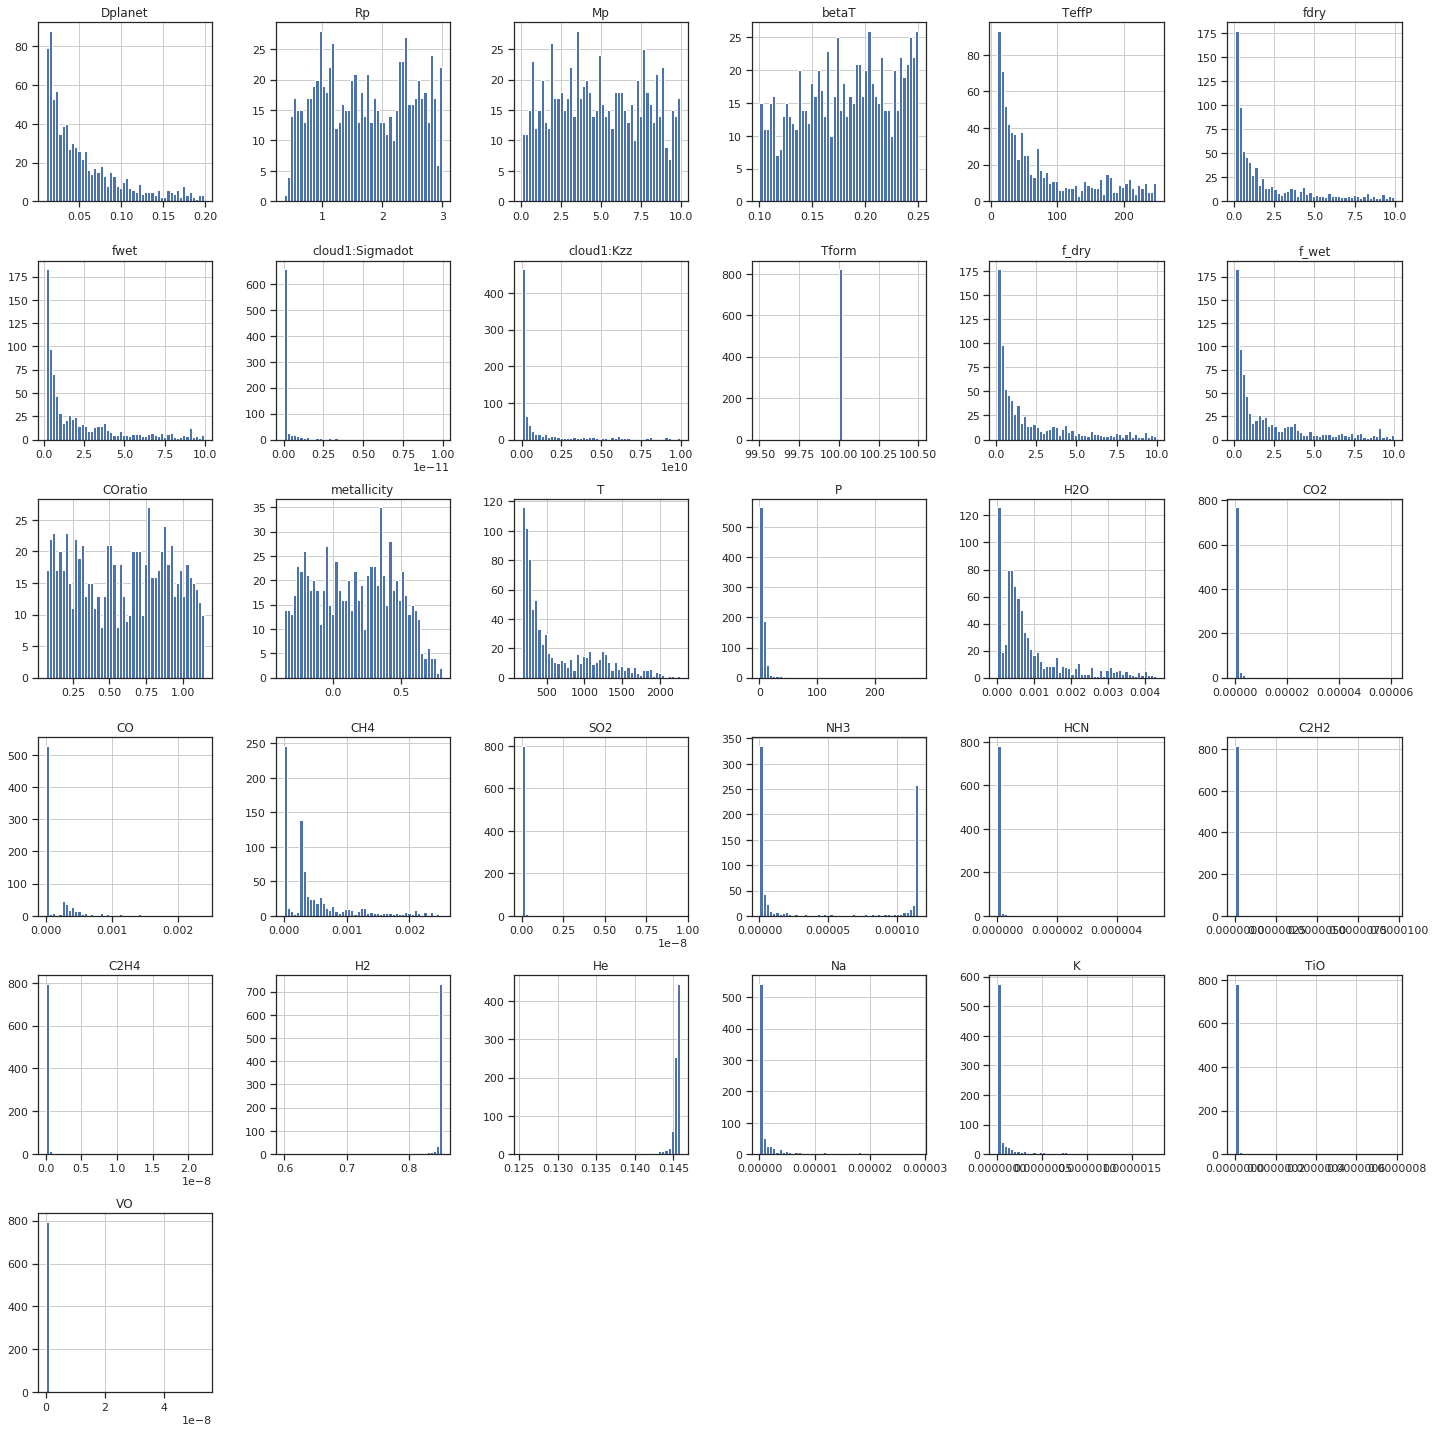

In [26]:
plt.figure(figsize=(20,20))
for i in range(len(df.columns)):
    plt.subplot(6,6,i+1)
    plt.title(df.columns[i])
    plt.hist(df.iloc[:,i], bins=50)
    plt.grid()
 
plt.tight_layout()

# Convert logarithmic sampled parameters to log scale

‘Dplanet’: afstand van de planeet tot de ster in AU (log10)  
‘Rp’: Straal van de planeet in Rjup (lineair)  
‘Mp’: Massa van de planeet in Mjup (lineair)  
‘betaT’: efficienty van instraling (lineair)    
‘TeffP’: interne temperatuur in K (log10)  
‘fdry’: accretie van sollid materiaal in de atmosfeer (log10)  
‘fwet’: accretie van waterijs (log10)  
'cloud1:Sigmadot’: nucleation rate voor de wolken (log10)  
'cloud1:Kzz’: mixing efficiency voor de wolkvorming (log10)  
‘Tform’: vormingstemperatuur (nu altijd op 100K)  
‘f_dry’: zelfde als boven  
‘f_wet’: zelfde als boven  
‘COratio’: verhouding tussen C en O in de atmosfeer; afgeleid van f_dry en f_wet  
‘metallicity’: fractie zware elementen; afgeleid van f_dry en f_wet  
’T’: temperatuur op de hoogte in de atmosfeer die het meest bijdraagt aan het spectrum  
‘P’: druk op deze hoogte in de atmosfeer  
'H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN’, 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', ‘VO’: abundanties van de moleculen op deze hoogte in de atmosfeer  

# TODO : 

Check which params are logarithmic sampled. 
Are they log10 or log (natural)?

In [27]:
df.columns

Index(['Dplanet', 'Rp', 'Mp', 'betaT', 'TeffP', 'fdry', 'fwet',
       'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio',
       'metallicity', 'T', 'P', 'H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN',
       'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'],
      dtype='object')

In [28]:
# TO DO 

to_log10 = ['H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO']
to_log = ['Dplanet', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'f_dry', 'f_wet', 'P', ]

df[to_log10] = np.log10(df[to_log10])
df[to_log] = np.log10(df[to_log])

In [29]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

df.describe()

,Dplanet,Rp,Mp,betaT,TeffP,fdry,fwet,cloud1:Sigmadot,cloud1:Kzz,Tform,...,NH3,HCN,C2H2,C2H4,H2,He,Na,K,TiO,VO
count,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.0,...,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000
mean,-1.396592,1.719994,4.951009,0.181790,1.722525,0.028380,0.010661,-15.158417,8.031267,100.0,...,-5.205220,-25.156938,-38.464183,-25.814329,-0.071051,-0.838132,-15.525417,-17.365685,-20.712939,-20.847754
std,0.345793,0.737985,2.783892,0.042628,0.414369,0.574743,0.579433,2.314873,1.174909,0.0,...,1.285962,16.396930,27.775010,14.855619,0.010497,0.004647,11.652640,12.141409,11.522152,10.453785
min,-1.996950,0.359299,0.051526,0.100199,1.000300,-0.999707,-0.999008,-18.999912,6.006349,100.0,...,-8.977984,-61.508078,-98.319574,-58.143271,-0.222863,-0.902049,-54.437826,-57.704433,-58.780940,-42.037820
25%,-1.690315,1.062533,2.583130,0.147905,1.366665,-0.475525,-0.480883,-17.156926,7.018427,100.0,...,-6.229444,-38.092481,-60.780685,-37.741790,-0.070019,-0.838033,-23.999255,-26.212869,-29.390079,-29.934497
50%,-1.408310,1.681432,4.838264,0.184676,1.714505,0.026771,0.000647,-15.314713,8.026018,100.0,...,-5.077482,-20.939680,-30.118844,-21.533726,-0.069204,-0.837137,-10.445632,-12.104799,-18.504456,-19.215454
75%,-1.123868,2.377842,7.397306,0.217284,2.102798,0.553063,0.525474,-13.176779,9.047389,100.0,...,-3.940815,-9.674383,-12.072809,-11.878853,-0.068796,-0.836839,-5.774315,-7.144143,-9.837586,-10.619067
max,-0.701158,2.998385,9.990271,0.249983,2.396719,0.997776,0.999253,-11.001702,9.999255,100.0,...,-3.936291,-5.273762,-5.013363,-7.652475,-0.068491,-0.835945,-4.541967,-5.753009,-6.103529,-7.269622


In [30]:
df.isna().sum()

Dplanet            0
Rp                 0
Mp                 0
betaT              0
TeffP              0
fdry               0
fwet               0
cloud1:Sigmadot    0
cloud1:Kzz         0
Tform              0
f_dry              0
f_wet              0
COratio            0
metallicity        0
T                  0
P                  0
H2O                0
CO2                0
CO                 0
CH4                0
SO2                0
NH3                0
HCN                0
C2H2               0
C2H4               0
H2                 0
He                 0
Na                 0
K                  0
TiO                0
VO                 0
dtype: int64

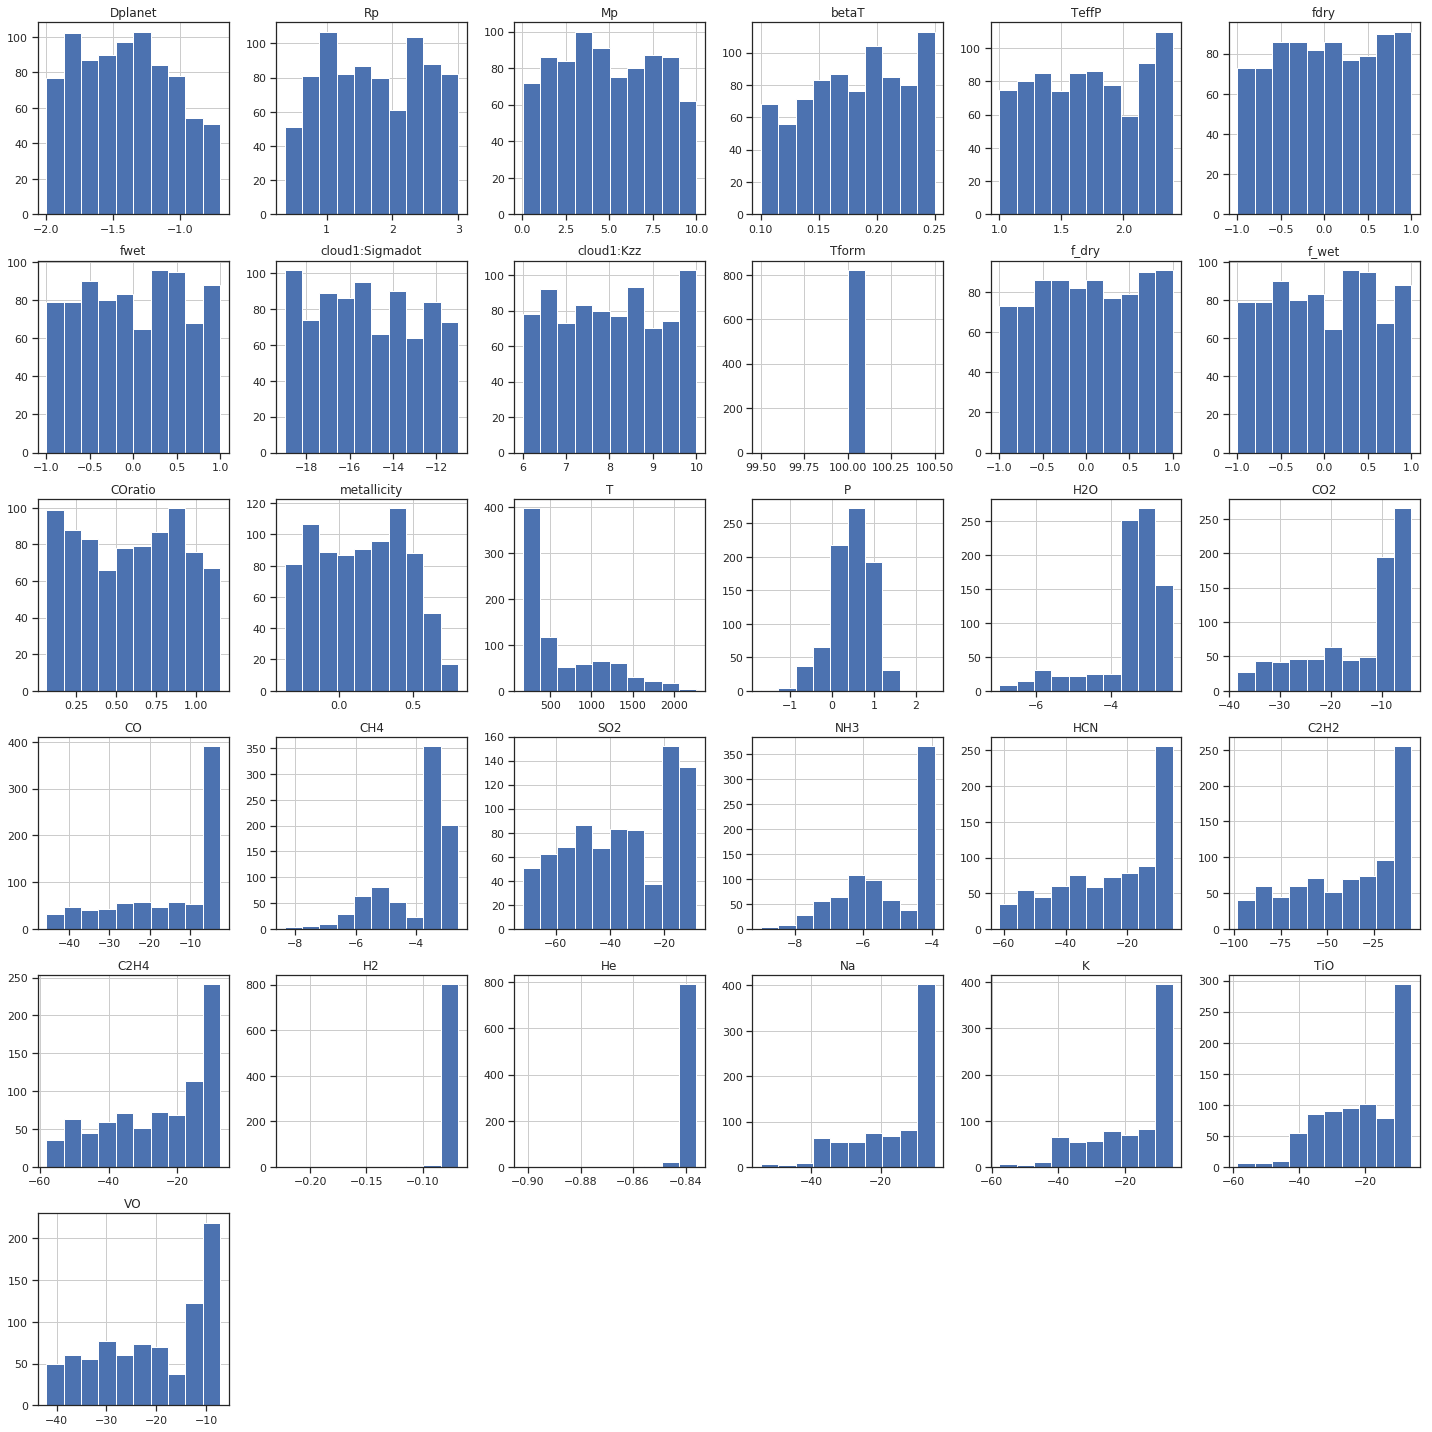

In [31]:
plt.figure(figsize=(20,20))

for i in range(len(df.columns)):
    plt.subplot(6,6,i+1)
    plt.title(df.columns[i])
    plt.hist(df.iloc[:,i], bins=10)
    plt.grid()
    
plt.tight_layout()

In [32]:
params_dict = df.to_dict('list') # convert df to dict

In [33]:
del params_dict['Tform'] # delete this because it's only one value...

In [34]:
# convert lists to np arrays
for key in params_dict.keys():
    params_dict[key] = np.array(params_dict[key])

# Split ARCiS only from ExoGAN params
Just so it's easier to fill the top and bottom of the ASPA seperately.

ExoGAN:  

    'planet_mass': [],
    'temp_profile': [],
    'ch4_mixratio': [],
    'planet_radius': [],
    'h2o_mixratio': [],
    'co2_mixratio': [],
    'co_mixratio': []

In [35]:
keys = list(params_dict.keys())

In [36]:
exo_param_names = ['Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO']

exo = {key: params_dict[key] for key in exo_param_names} # create dict with exo params

In [37]:
# create arcis params dict

arcis = copy.deepcopy(params_dict)

for key in exo_param_names: # remove exo params so only arcis params are left
    del arcis[key]

# Exo mins and maxs

In [38]:
# grab min max values per key
mins_exo = np.array([min(exo[key]) for key in exo.keys()])
maxs_exo = np.array([max(exo[key]) for key in exo.keys()])

exo.keys()

dict_keys(['Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO'])

In [39]:
mins_exo

array([ 5.15264270e-02,  1.64857000e+02, -8.35546294e+00,  3.59299320e-01,
       -6.97021053e+00, -3.83690639e+01, -4.56307841e+01])

In [40]:
maxs_exo

array([   9.9902707 , 2274.052     ,   -2.59791065,    2.9983846 ,
         -2.36683465,   -4.21246868,   -2.62051319])

# ARCiS mins and maxs

In [41]:
# grab min max values per key
mins_arcis = np.array([min(arcis[key]) for key in arcis.keys()])
maxs_arcis = np.array([max(arcis[key]) for key in arcis.keys()])

arcis.keys()

dict_keys(['Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'])

In [42]:
mins_arcis

array([-1.99695035e+00,  1.00198890e-01,  1.00029969e+00, -9.99707211e-01,
       -9.99008336e-01, -1.89999116e+01,  6.00634934e+00, -9.99707211e-01,
       -9.99008336e-01,  6.39209310e-02, -3.65279880e-01, -1.69875291e+00,
       -7.22906452e+01, -8.97798426e+00, -6.15080783e+01, -9.83195738e+01,
       -5.81432711e+01, -2.22863287e-01, -9.02048929e-01, -5.44378261e+01,
       -5.77044329e+01, -5.87809397e+01, -4.20378201e+01])

In [43]:
maxs_arcis

array([ -0.70115803,   0.24998323,   2.39671886,   0.99777636,
         0.99925298, -11.00170173,   9.99925521,   0.99777636,
         0.99925298,   1.1496769 ,   0.80842118,   2.43996394,
        -8.01976931,  -3.93629144,  -5.27376195,  -5.0133626 ,
        -7.65247484,  -0.06849128,  -0.83594471,  -4.54196681,
        -5.7530093 ,  -6.1035289 ,  -7.26962153])

# Exo: Test transform each parameter

## Exo: Hist, original

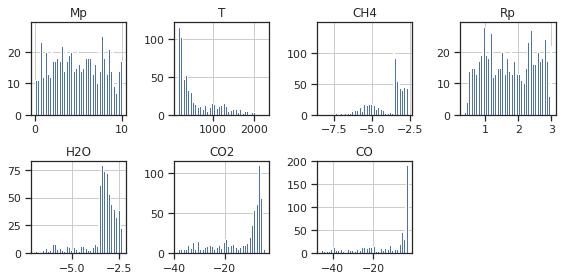

In [44]:
plt.figure(figsize=(8,4))

for i,key in enumerate(exo.keys()):
    plt.subplot(2,4,i+1)
    plt.title(key)
    plt.hist(exo[key], bins=50)
    plt.grid()
    
plt.tight_layout()

In [45]:
"""
exo params

in order: 'Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'
"""

mins = [1.03709980e-02,  1.17939000e+02, -1.15780672e+01,  1.06085820e-01,
       -2.60739664e+01, -7.13744818e+01, -5.65058454e+01]

maxs = [9.99992070e+00,  4.49183800e+03, -2.59602204e+00,  2.99990960e+00,
       -1.55346283e+00, -3.81987412e+00, -2.60049934e+00]

for i,key in enumerate(exo):
    exo[key] = ke.scale_param(exo[key], mins[i], maxs[i])

## Exo: Hist, transformed

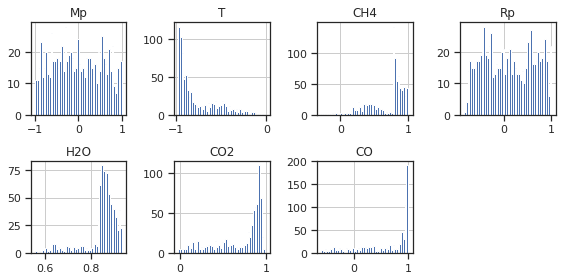

In [46]:
plt.figure(figsize=(8,4))

for i,key in enumerate(exo.keys()):
    plt.subplot(2,4,i+1)
    plt.title(key)
    plt.hist(exo[key], bins=50)
    plt.grid()
    
plt.tight_layout()

# ARCiS: Test transform each parameter

## ARCiS: Hist, original

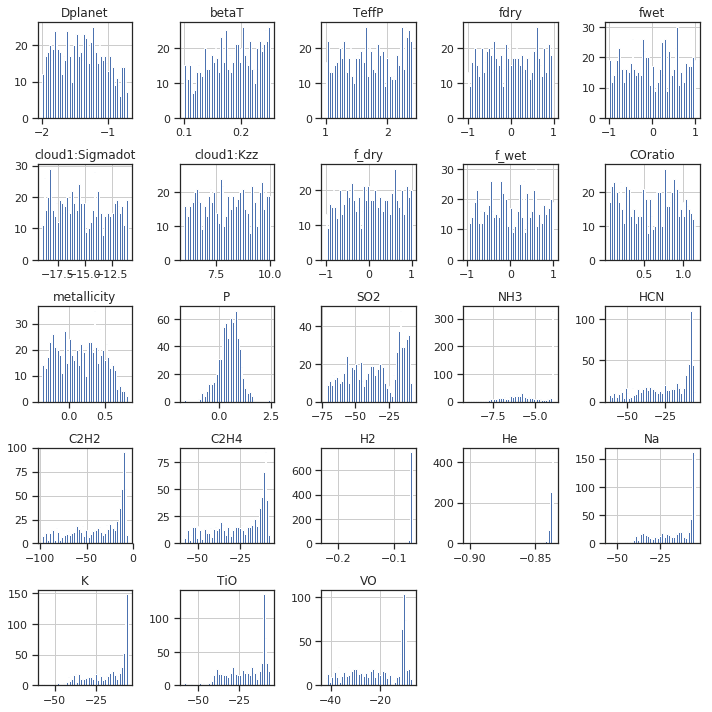

In [47]:
plt.figure(figsize=(10,10))

for i,key in enumerate(arcis.keys()):
    plt.subplot(5,5,i+1)
    plt.title(key)
    plt.hist(arcis[key], bins=50)
    plt.grid()
    
plt.tight_layout()

In [48]:
"""
arcis params

in order: 'Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'
"""

mins = np.array([-1.99999309e+00,  1.00001580e-01,  1.00003809e+00, -9.99982368e-01,
       -9.99997568e-01, -1.89999116e+01,  6.00000439e+00, -9.99982368e-01,
       -9.99997568e-01,  5.79562710e-02, -3.75368250e-01, -3.46635502e+00,
       -9.85062632e+01, -1.03949105e+01, -6.24317983e+01, -9.89991323e+01,
       -5.87249191e+01, -9.09036923e-01, -1.05571478e+00, -5.55917600e+01,
       -5.88667805e+01, -6.05094797e+01, -4.31835598e+01])

maxs = np.array([-0.69897819,   0.2499957 ,   2.39792597,   0.99995036,
         0.99999482, -11.00013972,   9.99996661,   0.99995036,
         0.99999482,   1.1560853 ,   0.825827  ,   2.95588009,
        -5.67964597,  -3.93591656,  -4.85542579,  -4.23306691,
        -6.86043573,  -0.06844043,  -0.82623118,  -4.52988365,
        -5.74112337,  -5.88773023,  -6.99353396])

for i,key in enumerate(arcis):
    arcis[key] = ke.scale_param(arcis[key], mins[i], maxs[i])

## ARCiS: Hist, transformed

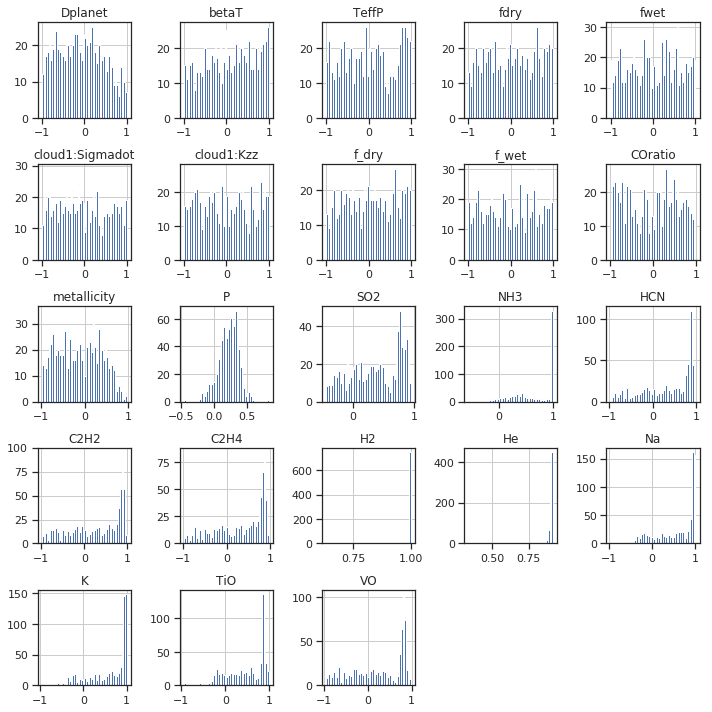

In [49]:
plt.figure(figsize=(10,10))

for i,key in enumerate(arcis.keys()):
    plt.subplot(5,5,i+1)
    plt.title(key)
    plt.hist(arcis[key], bins=50)
    plt.grid()
    
plt.tight_layout()

# MakeAI ARCiS ASPA
To inverse scale ASPA the x values would have to be known (or save a fixed wnw grid for arcis).

In [50]:
"""function inputs"""
i = 0
trans_file = trans_[i] # paths to files
params_file = params_[i]
ariels_file = ariels[i]






"""Get spectrum"""
trans = np.loadtxt(trans_file)
data = match_arcis_to_exogan_lambda_values(trans) # contains df.x and df.y (lambda and R/R)

"""Get params"""
params = get_arcis_makeai_params(params_file)
abundances = get_makeai_abundances(ariels_file)

params = {**params, **abundances} # create one dict from params and abundances dicts, calling it params 

del params['Tform'] # delete this because it's only one value...

"""Transform certain parameters from linear to log10 scale"""
# TO DO: Find out form Michiel what's been sampled in which way

to_log10 = ['H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO']
to_log = ['Dplanet', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'f_dry', 'f_wet', 'P', ]

# convert scales
for key in to_log10:
    params[key] = np.log10(params[key])
    
for key in to_log:
    params[key] = np.log(params[key])
    
# make sure everything is a ndarray
for key in params.keys():
    params[key] = np.array(params[key])

"""seperate dict into exo dict and arcis dict"""
exo_param_names = ['Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO']

exo = {key: params[key] for key in exo_param_names} # create dict with exo params

# create arcis params dict
arcis = copy.deepcopy(params)

for key in exo_param_names: # remove exo params so only arcis params are left
    del arcis[key]
    
    
"""normalization"""

"""
exo params

in order: ''Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO'
"""

mins = [1.03709980e-02,  1.17939000e+02, -1.15780672e+01,  1.06085820e-01,
       -2.60739664e+01, -7.13744818e+01, -5.65058454e+01]

maxs = [9.99992070e+00,  4.49183800e+03, -2.59602204e+00,  2.99990960e+00,
       -1.55346283e+00, -3.81987412e+00, -2.60049934e+00]

for i,key in enumerate(exo):
    exo[key] = ke.scale_param(exo[key], mins[i], maxs[i])
    
"""
arcis params

in order: 'Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'
"""

mins = np.array([-1.99999309e+00,  1.00001580e-01,  1.00003809e+00, -9.99982368e-01,
       -9.99997568e-01, -1.89999116e+01,  6.00000439e+00, -9.99982368e-01,
       -9.99997568e-01,  5.79562710e-02, -3.75368250e-01, -3.46635502e+00,
       -9.85062632e+01, -1.03949105e+01, -6.24317983e+01, -9.89991323e+01,
       -5.87249191e+01, -9.09036923e-01, -1.05571478e+00, -5.55917600e+01,
       -5.88667805e+01, -6.05094797e+01, -4.31835598e+01])

maxs = np.array([-0.69897819,   0.2499957 ,   2.39792597,   0.99995036,
         0.99999482, -11.00013972,   9.99996661,   0.99995036,
         0.99999482,   1.1560853 ,   0.825827  ,   2.95588009,
        -5.67964597,  -3.93591656,  -4.85542579,  -4.23306691,
        -6.86043573,  -0.06844043,  -0.82623118,  -4.52988365,
        -5.74112337,  -5.88773023,  -6.99353396])

for i,key in enumerate(arcis):
    arcis[key] = ke.scale_param(arcis[key], mins[i], maxs[i])
    
""" Select spectrum bins """
# Could loop this, but right now this is more visual
# H2O bins
bin1 = data[data.x <= 0.44]
bin2 = data[(data.x > 0.44) & (data.x <= 0.495)]
bin3 = data[(data.x > 0.495) & (data.x <= 0.535)]
bin4 = data[(data.x > 0.535) & (data.x <= 0.58)]
bin5 = data[(data.x > 0.58) & (data.x <= 0.635)]
bin6 = data[(data.x > 0.635) & (data.x <= 0.71)]
bin7 = data[(data.x > 0.71) & (data.x <= 0.79)]
bin8 = data[(data.x > 0.79) & (data.x <= 0.9)]
bin9 = data[(data.x > 0.9) & (data.x <= 1.08)]
bin10 = data[(data.x > 1.08) & (data.x <= 1.3)]
bin11 = data[(data.x > 1.3) & (data.x <= 1.7)]
bin12 = data[(data.x > 1.7) & (data.x <= 2.35)]

# Manually chosen bins
bin13 = data[(data.x > 2.35) & (data.x <= 4)]
bin14 = data[(data.x > 4) & (data.x <= 6)]
bin15 = data[(data.x > 6) & (data.x <= 10)]
bin16 = data[(data.x > 10) & (data.x <= 14)]
bin17 = data[data.x > 14]

bins = [bin17, bin16, bin15, bin14, bin13, bin12, bin11, bin10, bin9, bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]

"""
Normalize bins
"""
scalers = [MinMaxScaler(feature_range=(-1,1)).fit(b) for b in bins] # list of ... scalers for the ... bins
mins = [ b.iloc[:,1].min() for b in bins] # .iloc[:,1] selects all rows from column 1 (which is R/R)
maxs = [ b.iloc[:,1].max() for b in bins]

bins_scaled = []
for i,b in enumerate(bins):
    bins_scaled.append(scalers[i].transform(b))

spectrum_scaled = np.concatenate(bins_scaled, axis=0)
spectrum_scaled = spectrum_scaled[:,1]

"""Spectrum"""
aspa = np.zeros((32,32))

row_length = 25 # amount of pixels used per row
n_rows = math.ceil(len(spectrum_scaled) / row_length) # amount of rows the spectrum needs in the aspa, so for 415 data points, 415/32=12.96 -> 13 rows
#print('Using %s rows' % n_rows)

for i in range(n_rows): # for i in 
    start = i*row_length
    stop = start+row_length
    spec = spectrum_scaled[start:stop]

    if len(spec) != row_length:
        n_missing_points = row_length-len(spec)
        spec = np.append(spec, [0 for _ in range(n_missing_points)]) # for last row, if length != 32, fill remaining with 0's
        #print('Filled row with %s points' % n_missing_points)

    aspa[i, :row_length] = spec
    
"""exo params"""
for i,key in enumerate(exo_param_names): # !!!!!! Need to grab the keys list which is in order, python <3.7 reorders the created dict
    aspa[:16, 25+i:26+i] = exo[key]
    
"""min max values for spectrum bins"""
for i in range(len(mins)):
    min_ = ke.scale_param(mins[i], 0.00024601534 , 0.1710588)
    max_ = ke.scale_param(maxs[i], 0.00024601534 , 0.1710588)

    aspa[16:17, i*2:i*2+2] = min_
    aspa[17:18, i*2:i*2+2] = max_

    
    
    
    
    
#"""Fill unused space with noice"""
#for i in range(14):
#    noise = np.random.rand(32) # random noise betweem 0 and 1 for each row
#    aspa[18+i:19+i*1, :] = noise
 
for i,key in enumerate(arcis.keys()):
    value = arcis[key]
    aspa[18:, i:i+1] = value
    
"""Fill unused space with some params, just so there is structure to the unused space"""
for i,key in enumerate(arcis.keys()):
    value = arcis[key]
    aspa[18+i:19+i, 23:] = value


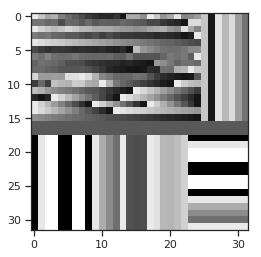

In [51]:
plt.imshow(aspa, cmap='gray', vmin=-1.2, vmax=1.2)

# Functionize ASPA creation

In [52]:
def ASPA_complex_v1(trans_file, params_file, ariels_file):
    """
    trans_file, params_file, ariels_file: file paths to respective arcis makeai files
    
    output: ndarray shape(32,32)
    """
    
    """Get spectrum"""
    trans = np.loadtxt(trans_file)
    data = match_arcis_to_exogan_lambda_values(trans) # contains df.x and df.y (lambda and R/R)

    """Get params"""
    params = get_arcis_makeai_params(params_file)
    abundances = get_makeai_abundances(ariels_file)

    params = {**params, **abundances} # create one dict from params and abundances dicts, calling it params 

    del params['Tform'] # delete this because it's only one value...

    """Transform certain parameters from linear to log10 scale"""
    # TO DO: Find out form Michiel what's been sampled in which way

    to_log10 = ['H2O', 'CO2', 'CO', 'CH4', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO']
    to_log = ['Dplanet', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'f_dry', 'f_wet', 'P', ]

    # convert scales
    for key in to_log10:
        params[key] = np.log10(params[key])

    for key in to_log:
        params[key] = np.log(params[key])

    # make sure everything is a ndarray
    for key in params.keys():
        params[key] = np.array(params[key])

    """seperate dict into exo dict and arcis dict"""
    exo_param_names = ['Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO']

    exo = {key: params[key] for key in exo_param_names} # create dict with exo params

    # create arcis params dict
    arcis = copy.deepcopy(params)

    for key in exo_param_names: # remove exo params so only arcis params are left
        del arcis[key]


    """normalization"""

    """
    exo params

    in order: ''Mp', 'T', 'CH4', 'Rp', 'H2O', 'CO2', 'CO'
    """

    mins = [1.03709980e-02,  1.17939000e+02, -1.15780672e+01,  1.06085820e-01,
           -2.60739664e+01, -7.13744818e+01, -5.65058454e+01]

    maxs = [9.99992070e+00,  4.49183800e+03, -2.59602204e+00,  2.99990960e+00,
           -1.55346283e+00, -3.81987412e+00, -2.60049934e+00]

    for i,key in enumerate(exo):
        exo[key] = ke.scale_param(exo[key], mins[i], maxs[i])

    """
    arcis params

    in order: 'Dplanet', 'betaT', 'TeffP', 'fdry', 'fwet', 'cloud1:Sigmadot', 'cloud1:Kzz', 'Tform', 'f_dry', 'f_wet', 'COratio', 'metallicity', 'P', 'SO2', 'NH3', 'HCN', 'C2H2', 'C2H4', 'H2', 'He', 'Na', 'K', 'TiO', 'VO'
    """

    mins = np.array([-1.99999309e+00,  1.00001580e-01,  1.00003809e+00, -9.99982368e-01,
           -9.99997568e-01, -1.89999116e+01,  6.00000439e+00, -9.99982368e-01,
           -9.99997568e-01,  5.79562710e-02, -3.75368250e-01, -3.46635502e+00,
           -9.85062632e+01, -1.03949105e+01, -6.24317983e+01, -9.89991323e+01,
           -5.87249191e+01, -9.09036923e-01, -1.05571478e+00, -5.55917600e+01,
           -5.88667805e+01, -6.05094797e+01, -4.31835598e+01])

    maxs = np.array([-0.69897819,   0.2499957 ,   2.39792597,   0.99995036,
             0.99999482, -11.00013972,   9.99996661,   0.99995036,
             0.99999482,   1.1560853 ,   0.825827  ,   2.95588009,
            -5.67964597,  -3.93591656,  -4.85542579,  -4.23306691,
            -6.86043573,  -0.06844043,  -0.82623118,  -4.52988365,
            -5.74112337,  -5.88773023,  -6.99353396])

    for i,key in enumerate(arcis):
        arcis[key] = ke.scale_param(arcis[key], mins[i], maxs[i])

    """ Select spectrum bins """
    # Could loop this, but right now this is more visual
    # H2O bins
    bin1 = data[data.x <= 0.44]
    bin2 = data[(data.x > 0.44) & (data.x <= 0.495)]
    bin3 = data[(data.x > 0.495) & (data.x <= 0.535)]
    bin4 = data[(data.x > 0.535) & (data.x <= 0.58)]
    bin5 = data[(data.x > 0.58) & (data.x <= 0.635)]
    bin6 = data[(data.x > 0.635) & (data.x <= 0.71)]
    bin7 = data[(data.x > 0.71) & (data.x <= 0.79)]
    bin8 = data[(data.x > 0.79) & (data.x <= 0.9)]
    bin9 = data[(data.x > 0.9) & (data.x <= 1.08)]
    bin10 = data[(data.x > 1.08) & (data.x <= 1.3)]
    bin11 = data[(data.x > 1.3) & (data.x <= 1.7)]
    bin12 = data[(data.x > 1.7) & (data.x <= 2.35)]

    # Manually chosen bins
    bin13 = data[(data.x > 2.35) & (data.x <= 4)]
    bin14 = data[(data.x > 4) & (data.x <= 6)]
    bin15 = data[(data.x > 6) & (data.x <= 10)]
    bin16 = data[(data.x > 10) & (data.x <= 14)]
    bin17 = data[data.x > 14]

    bins = [bin17, bin16, bin15, bin14, bin13, bin12, bin11, bin10, bin9, bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]

    """
    Normalize bins
    """
    scalers = [MinMaxScaler(feature_range=(-1,1)).fit(b) for b in bins] # list of ... scalers for the ... bins
    mins = [ b.iloc[:,1].min() for b in bins] # .iloc[:,1] selects all rows from column 1 (which is R/R)
    maxs = [ b.iloc[:,1].max() for b in bins]

    bins_scaled = []
    for i,b in enumerate(bins):
        bins_scaled.append(scalers[i].transform(b))

    spectrum_scaled = np.concatenate(bins_scaled, axis=0)
    spectrum_scaled = spectrum_scaled[:,1]

    """Spectrum"""
    aspa = np.zeros((32,32))

    row_length = 25 # amount of pixels used per row
    n_rows = math.ceil(len(spectrum_scaled) / row_length) # amount of rows the spectrum needs in the aspa, so for 415 data points, 415/32=12.96 -> 13 rows
    #print('Using %s rows' % n_rows)

    for i in range(n_rows): # for i in 
        start = i*row_length
        stop = start+row_length
        spec = spectrum_scaled[start:stop]

        if len(spec) != row_length:
            n_missing_points = row_length-len(spec)
            spec = np.append(spec, [0 for _ in range(n_missing_points)]) # for last row, if length != 32, fill remaining with 0's
            #print('Filled row with %s points' % n_missing_points)

        aspa[i, :row_length] = spec

    """exo params"""
    for i,key in enumerate(exo_param_names): # !!!!!! Need to grab the keys list which is in order, python <3.7 reorders the created dict
        aspa[:16, 25+i:26+i] = exo[key]

    """min max values for spectrum bins"""
    for i in range(len(mins)):
        min_ = ke.scale_param(mins[i], 0.00024601534 , 0.1710588)
        max_ = ke.scale_param(maxs[i], 0.00024601534 , 0.1710588)

        aspa[16:17, i*2:i*2+2] = min_
        aspa[17:18, i*2:i*2+2] = max_






    #"""Fill unused space with noice"""
    #for i in range(14):
    #    noise = np.random.rand(32) # random noise betweem 0 and 1 for each row
    #    aspa[18+i:19+i*1, :] = noise

    for i,key in enumerate(arcis.keys()):
        value = arcis[key]
        aspa[18:, i:i+1] = value

    """Fill unused space with some params, just so there is structure to the unused space"""
    for i,key in enumerate(arcis.keys()):
        value = arcis[key]
        aspa[18+i:19+i, 23:] = value
    
    return aspa

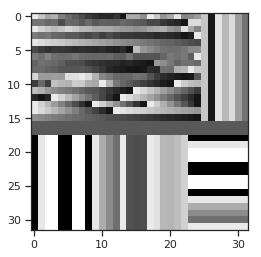

In [53]:
# try out

i = 0
trans_file = trans_[i] # paths to files
params_file = params_[i]
ariels_file = ariels[i]

aspa = ASPA_complex_v1(trans_file, params_file, ariels_file)

plt.imshow(aspa, cmap='gray', vmin=-1.2, vmax=1.2)